In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils_BL as rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        # self.fc1 = nn.Sequential(
        #     nn.Linear(state_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        self.fc_hidden1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden4 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc_hidden1(x)
        x = self.fc_hidden2(x)
        x = self.fc_hidden3(x)    
        x = self.fc_hidden4(x) 
        return torch.tanh(self.fc2(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        # self.fc1 = nn.Sequential(
        #     nn.Linear(state_dim + action_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        self.fc_hidden1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden4 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.fc_hidden5 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        # self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = self.fc_hidden1(x)
        x = self.fc_hidden2(x)
        x = self.fc_hidden3(x)
        x = self.fc_hidden4(x)
        x = self.fc_hidden5(x)
        # x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        #action = self.actor(state).item()
        action = self.actor(state).detach().cpu().numpy()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        # return action
        if len(action.shape) > 1 and action.shape[0] == 1:
            action = action.squeeze(0)
        return action
       

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络



3. `actor_lr = 5e-4 critic_lr = 5e-4` num_episodes = 500 hidden_dim = 128 `gamma = 0.9` tau = 0.005 buffer_size = 5000000 minimal_size = 10000 batch_size = 1024 sigma = 0.1 成功率0%
3. `actor_lr = 5e-5 critic_lr = 5e-5` num_episodes = 500 hidden_dim = 128 `gamma = 0.9` tau = 0.005 buffer_size =50000 minimal_size = 5000 `batch_size = 256` `sigma = 0.2` hide=4 成功率 1%
3. `actor_lr = 5e-3 critic_lr = 5e-3` num_episodes = 500 hidden_dim = 128 `gamma = 0.9` tau = 0.005 buffer_size =50000 minimal_size = 5000 `batch_size = 128` `sigma = 0.2` hide=4 成功率 1%
3. `actor_lr = 5e-3 critic_lr = 5e-3` num_episodes = 500 hidden_dim = 128 `gamma = 0.9` tau = 0.005 buffer_size =20000 minimal_size = 2000 `batch_size = 64` `sigma = 0.2` hide=4 成功率 24%

In [4]:
from env.water_env_ppo import FlowEnv as lenv
actor_lr = 8e-3
critic_lr = 8e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.9
tau = 0.005  # 软更新参数
buffer_size = 20000
minimal_size = 2000
batch_size = 64
sigma = 0.2  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'Pendulum-v0'
# env = gym.make(env_name)

levelcount = 3
turn_max_time = 5
flow_erro = 0.02 #误差5%

env = lenv(levelcount = levelcount, turn_time=turn_max_time,flow_erro =flow_erro,adjust_max_count=200,meted='DDPG')  
env.render()
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)
return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Jinzhao_hu\AppData\Local\Temp\ipykernel_12944\4066836555.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [21:18<00:00, 25.57s/it, episode=500, return=25.297] 


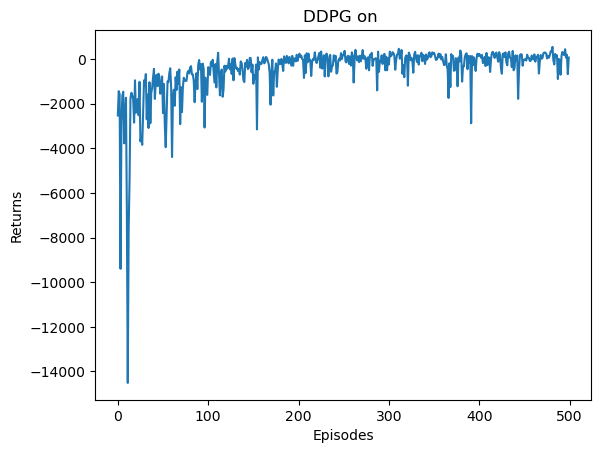

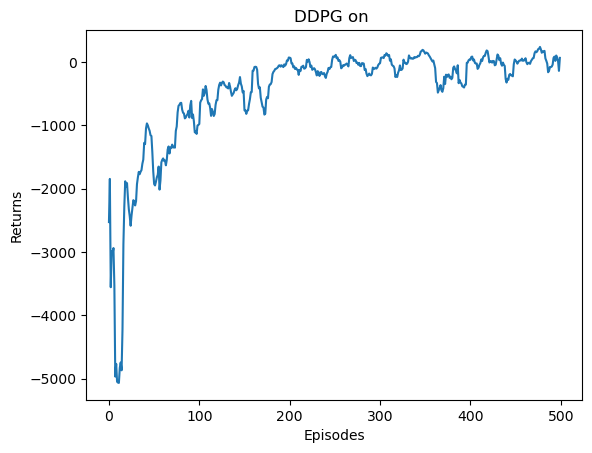

In [5]:
import pandas as pd

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(''))
plt.show()

# 创建一个字典，将数据整理成适合构建DataFrame的数据结构
data = {
    "Episodes": episodes_list,
    "Returns": return_list
}

# 使用字典创建DataFrame对象
df = pd.DataFrame(data)
# 创建只有一列数据的DataFrame
df = pd.DataFrame({"Returns": return_list})

# 将DataFrame保存为Excel文件，指定文件名为output.xlsx
df.to_excel(f"{levelcount}_DDPG_reward.xlsx", index=False)

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(''))
plt.show()

## 1.2 保存模型

In [204]:
torch.save(agent, f'model_{levelcount}_DDPG.pt')

## 1.3 加载模型

In [205]:
levelcount = 3
meted = "DDPG"

In [206]:

agent = torch.load(f'model_{levelcount}_DDPG.pt')

## 1.4 仿真验证

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from env.water_env_ppo import FlowEnv as lenv

In [208]:


turn_max_time = 5
env = lenv(levelcount = levelcount, turn_time=turn_max_time, flow_erro=0.05,adjust_max_count=100, meted='DDPG') 
# 
reward_list = np.array([])
Q_list = np.array([])
ta_list = np.array([])
#提取一个数据集
data = pd.read_excel(f'state_data_{levelcount}.xlsx')
# train_count = data.shape[0]
train_count = 99
for i in np.arange(train_count):
    data_row =np.array(data.iloc[i].values) 
    #data_row =np.array(data.iloc[59].values) 
    state =env.install(state =  data_row)
    done = False
    while not done:
        action = agent.take_action(state) #计算策略动作
        next_state, reward, done, _ = env.step(action)
        state = next_state
        reward_list = np.append(reward_list,reward)
    #翻译Q和ta
    temp_Qlist = np.array([])
    temp_ta = np.array([])
    sate_tran = env.trans_state(state)
    for i in np.arange(levelcount):
        temp_Qlist = np.append(temp_Qlist,sate_tran[4+i*5])
        temp_ta = np.append(temp_ta,sate_tran[5+i*5])      
    Q_list = np.concatenate((Q_list,temp_Qlist),axis=0)
    ta_list = np.concatenate((ta_list,temp_ta),axis=0)
Q_list = Q_list.reshape(-1,levelcount)
ta_list = ta_list.reshape(-1,levelcount)
# print (f'Q:{Q_list}')
# print (f'ta:{ta_list}')
# # print (f'ta:{reward_list}')

### 1.4.1 奖励函数

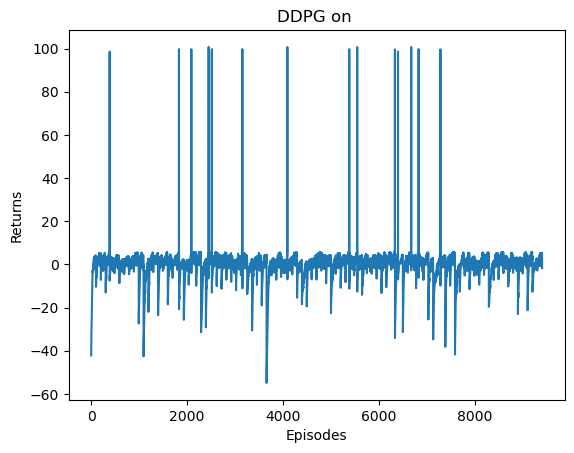

In [209]:
episodes_list = list(range(len(reward_list)))
plt.plot(episodes_list, reward_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(''))
plt.show()

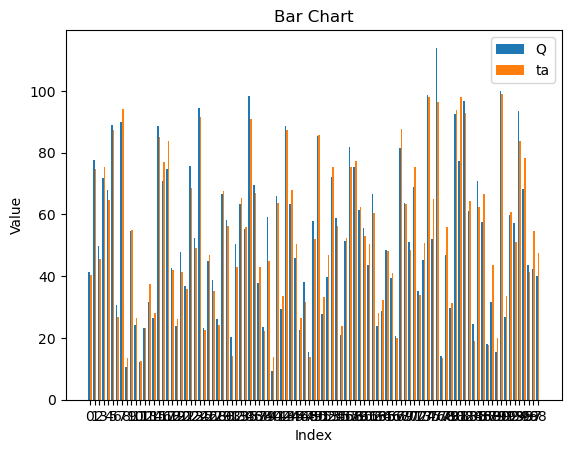

误差:0.10528624153825672


In [210]:
# 示例数据
# x = np.arange(train_count)
y1 = Q_list  # 第一组数据
y2 = ta_list  # 第二组数据

# 设置柱体的宽度
x = np.arange(y1.shape[0])
# Set width for bars
width = 0.35

# Plot y1 and y2 together
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1[:,0], width, label='Q')
rects2 = ax.bar(x + width/2, y2[:,0], width, label='ta')
# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Bar Chart')
ax.set_xticks(x)
ax.legend()

plt.show()
#平均误差
result =np.abs(y2-y1)/y2
# print(result)
# erro_avr =np.mean(np.sum(result)) 
erro_avr =np.sum(result)/(train_count*levelcount)  
print(f'误差:{erro_avr}')
df = pd.DataFrame(result)
df.to_excel(f'{levelcount}_{meted}_errodata.xlsx', index=False,header=False)

### 1.4.3调整平均次数

In [211]:
from openpyxl import load_workbook

# 打开Excel文件
workbook = load_workbook(f'{levelcount}_DDPG_RL_done.xlsx')

# 获取第一个工作表
sheet = workbook.active
# 从第二行开始，遍历第一列的所有单元格，取值并求和

sum_value = 0
count = 0
for row in sheet.iter_rows(min_row=2, min_col=1, max_col=1, values_only=True):
   if row[0] is not None and row[0] != 100:
        sum_value += row[0]
        count += 1
# 计算平均值
if count>0 :  
  average = sum_value / count
  print("和：", sum_value)
  print("平均值：", average)
  print('成功率：',count/train_count)

和： 808
平均值： 57.714285714285715
成功率： 0.1414141414141414
